<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 3: Holt-Winters exponential smoothing</h2></center>
<br>

Notebook basada en los visto en la materia de Análisis de Series Temporales. Se necesitan los siguientes imports:

In [96]:
import sys
IN_COLAB = 'google.colab' in sys.modules
DATA_FILE = 'demanda.csv'
RAW_REPO = 'https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/'
if IN_COLAB:
    DATA_FILE = RAW_REPO + DATA_FILE
    !wget -O get-x13as.sh {RAW_REPO + 'get-x13as.sh'}
    !sh get-x13as.sh
    !wget -O plotting.py {RAW_REPO + 'plotting.py'}

In [97]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [98]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

## Set de Datos de Demanda Eléctrica Mercado Argentino


In [99]:
data = pd.read_csv(DATA_FILE, index_col='TIPO', parse_dates=True)


data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


Se parsean las fechas para que sea mas simple manejar las series de datos. A continuación se plantea el análisis exploratorio de datos.

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2013-01-01 to 2019-07-01
Data columns (total 4 columns):
Residencial                    79 non-null float64
Comercial                      79 non-null float64
Industrial/Comercial Grande    79 non-null float64
TOTAL                          79 non-null float64
dtypes: float64(4)
memory usage: 3.1 KB


Se observa que el horizonte temporal de las series inicia en 2013 y finaliza en Julio de 2019. Siendo que apartir del año 2016 se lanzó la Revisión Tarifaria Integral aumentando considerablemente las tarifas apartir de ese año cada 6 meses, se espera ver un cambio de tendencia a partir de ese año.

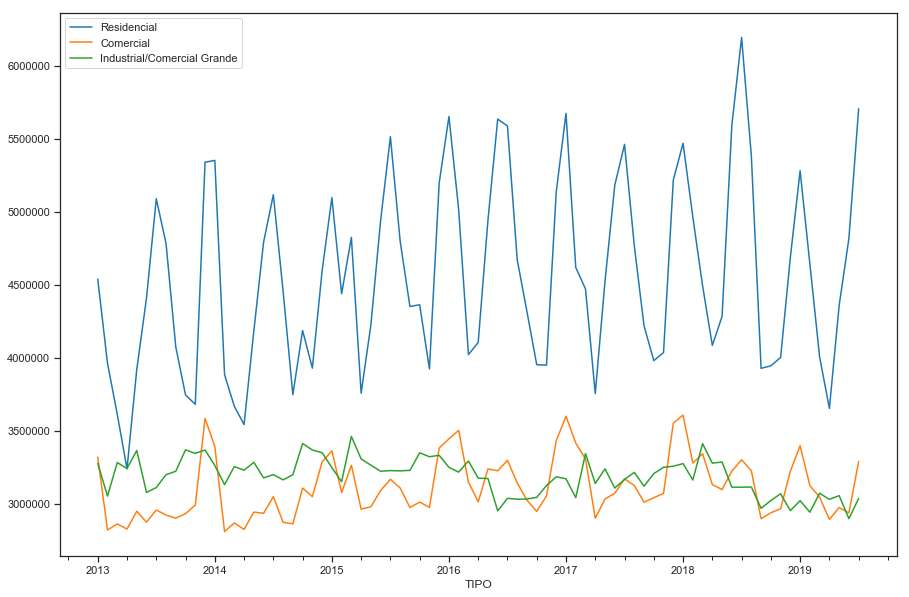

In [101]:
data_sin_tot = data.drop(columns=['TOTAL'])
data_sin_tot.plot()

El efecto del aumento de tarifas se puede ver reflejado en las series ya que a partir del año 2016 no se mantiene la tendencia creciente. Si se observa un pico alto en la demanda residencial del año 2018 probablemente por condiciones anormales de temperatura. 

A su vez se observa una estacionalidad en las series con picos en el verano por el consumo de los aires acondicionado y la refrigeración y en Julio por la calefacción.

## Análisis Demanda Residencial y Comercial

In [102]:
y_res = data['Residencial'].copy() 
y_res.index = y_res.index.to_period(freq='M')

ts_res = data['Residencial']

In [103]:
y_com = data['Comercial'].copy() 
y_com.index = y_com.index.to_period(freq='M')

ts_com = data['Comercial']

In [104]:
data_sin_tot.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande
count,79.00,79.00,79.00
mean,4551935.29,3113096.42,3187977.02
std,654164.93,206829.98,124659.74
min,3239380.70,2809183.13,2897618.67
25%,3990580.45,2948084.14,3109179.19
50%,4470715.12,3070853.24,3199317.20
75%,5092450.46,3270751.91,3275571.56
max,6193110.21,3606989.07,3460879.97


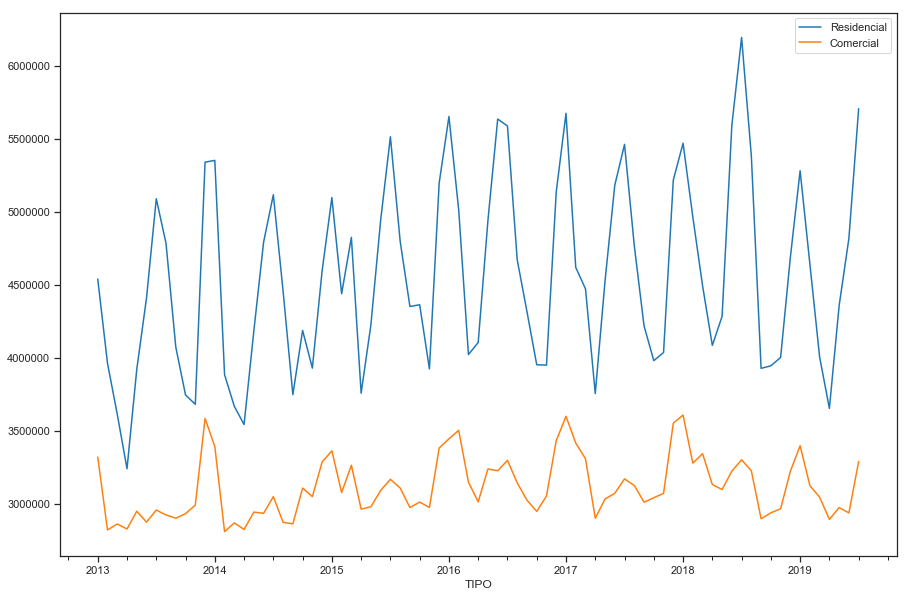

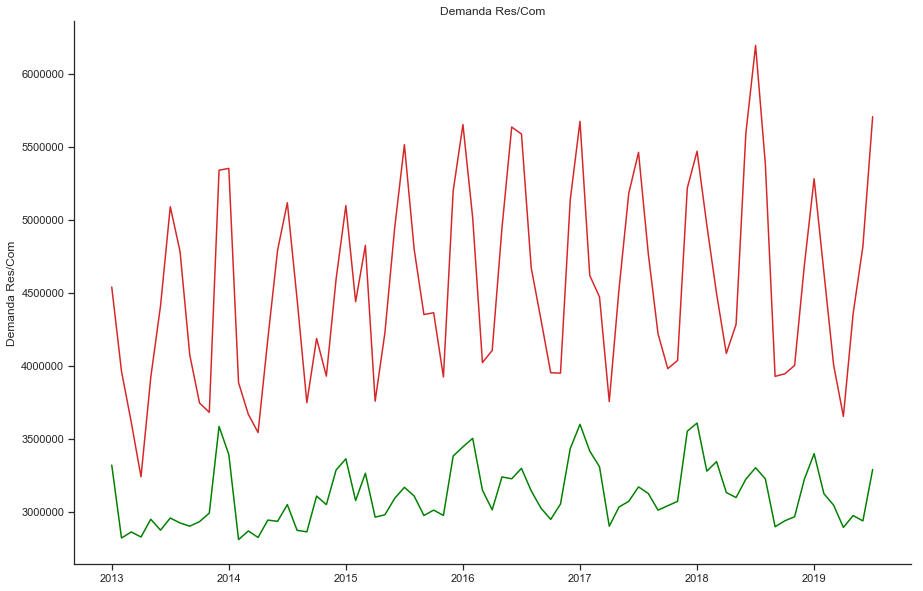

In [105]:
data_sin_tot.drop(columns=['Industrial/Comercial Grande']).plot()

fig, ax= plt.subplots();

data_sin_tot['Residencial'].plot(color=red)
data_sin_tot['Comercial'].plot(color='g')

ax.set_xlabel('')
ax.set_ylabel('Demanda Res/Com')
ax.set_title('Demanda Res/Com')
ax.set_xticks([], minor=True)

sns.despine()
plt.show()

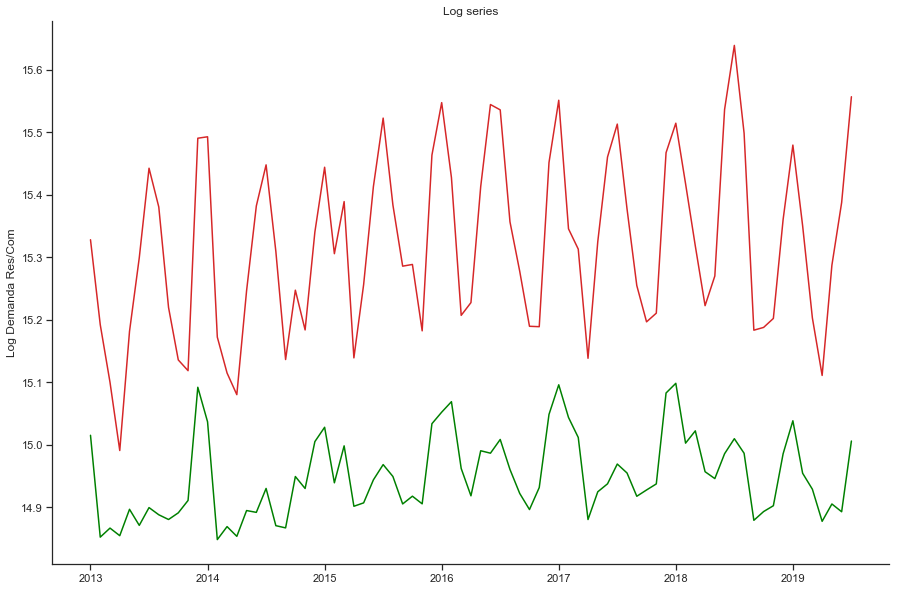

In [106]:
fig, ax= plt.subplots();

np.log(y_res).plot(color=red)
np.log(y_com).plot(color='g')

ax.set_xlabel('')
ax.set_ylabel('Log Demanda Res/Com')
ax.set_title('Log series')
ax.set_xticks([], minor=True)

sns.despine()
plt.show()

## Descomposición de las Series de Tiempo

Se toma el algoritmo expuesto en clase:

-------

We use the X-13 ARIMA-SEATS method for time series decomposition. The X-13 method is a state-of-art time series decomposition approach developed and provided by the [US Census Bureau](https://www.census.gov/srd/www/x13as/) as external software. You need to make the X-13 software available to Python by downloading it from the link and extracting the compressed folder to your computer. The <TT>statsmodels</TT> library has a function that interfaces with this software, and the easiest way to get it to work is to copy the <TT>x13as</TT> executable to the same folder as your notebook.  

The X-13 is the current version of the X-12-ARIMA method described in the [textbook](https://www.otexts.org/fpp/6/4). The only limitation is that the X-13 software makes calendar effect adjustments based on the US calendar by default, though it is possible to reconfigure it to other calendars. Refer to the [ABS](http://abs.gov.au/websitedbs/d3310114.nsf/4a256353001af3ed4b2562bb00121564/c890aa8e65957397ca256ce10018c9d8) for the seasonal adjustment standards in Australia.  

-----

In Linux you can use `get-x13as.sh` to get it.

In [107]:
import os
os.environ['X13PATH']='C:\\WinX13\\x13as\\'
decomposition_res = sm.tsa.x13_arima_analysis(ts_res)
decomposition_com = sm.tsa.x13_arima_analysis(ts_com)

C:\Users\Gabriel H\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


You can use the <TT>dir</TT> method to check the available output. 

In [108]:
[attr for attr in dir(decomposition_res) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [109]:
decomposition_res.seasadj.tail()

TIPO
2019-03-01    4.357587e+06
2019-04-01    4.448785e+06
2019-05-01    4.517256e+06
2019-06-01    4.351465e+06
2019-07-01    4.685038e+06
Name: seasadj, dtype: float64

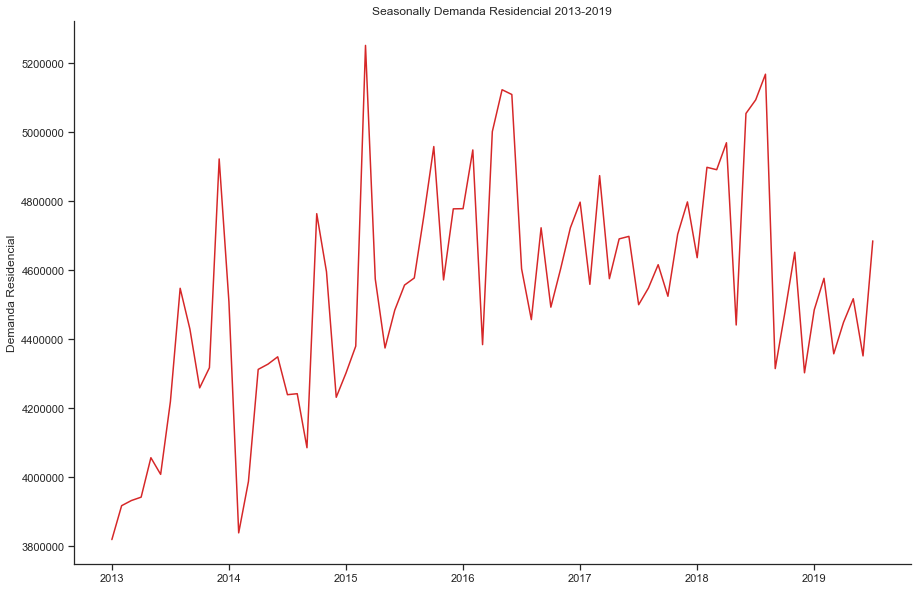

In [110]:
fig, ax= plt.subplots();#figsize=(9,6))
decomposition_res.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Demanda Residencial')
ax.set_title('Seasonally Demanda Residencial 2013-2019')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

Se usa el módulo <TT>plotting</TT> para graficar los componentes de la serie

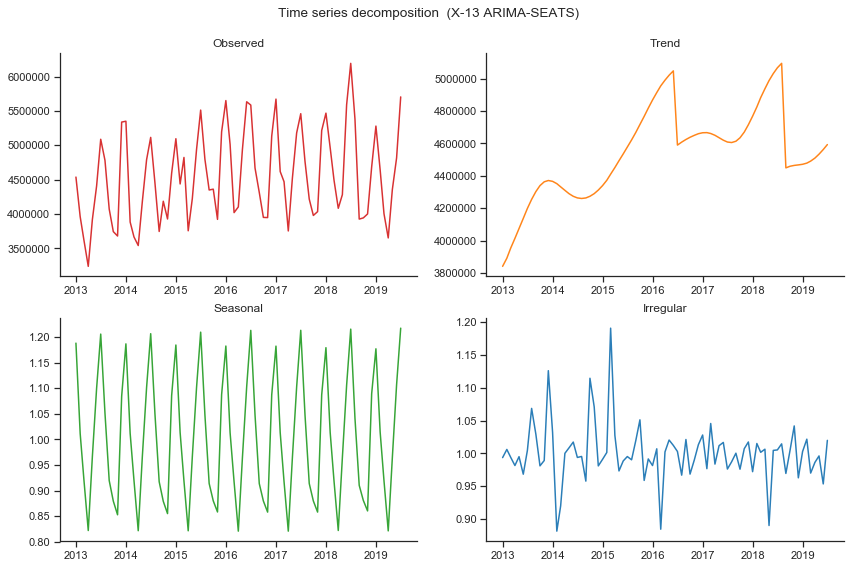

In [111]:
from plotting import plot_components_x13
plot_components_x13(decomposition_res)
plt.show()

Una vez descompuesta la serie, se observa la componente de estacionalidad muy marcada y sin variación en el tiempo ya que depende mas que nada de la temperatura. 

En cambio, la tendencia que iba en aumento desde comienzo de la serie hasta 2016, muestra una baja debido al antes mencionado aumento tarifario. Luego se observa el pico por las bajas temperaturas en el invierno de 2018 y vuelve a bajar para fines de la serie.

Se continua el análisis con el módulo X13 visto en clase.

The X-13-ARIMA software generates a very detailed analysis of the time series, which is stored in the <TT>results</TT> attribute. You can view it with the <TT>print(decomposition.results)</TT> command, but due to the length I recommend saving it to a text file and opening it elsewhere. You can do this as follows.  

In [112]:
f=open('x13results.txt', mode='w+')
f.write(decomposition_res.results)
f.close()

Se plantea el mismo análisis para la serie de Demanda Comercial:

In [113]:
[attr for attr in dir(decomposition_com) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

In [114]:
decomposition_com.seasadj.tail()

TIPO
2019-03-01    2.993987e+06
2019-04-01    3.040898e+06
2019-05-01    3.084785e+06
2019-06-01    2.997016e+06
2019-07-01    3.232357e+06
Name: seasadj, dtype: float64

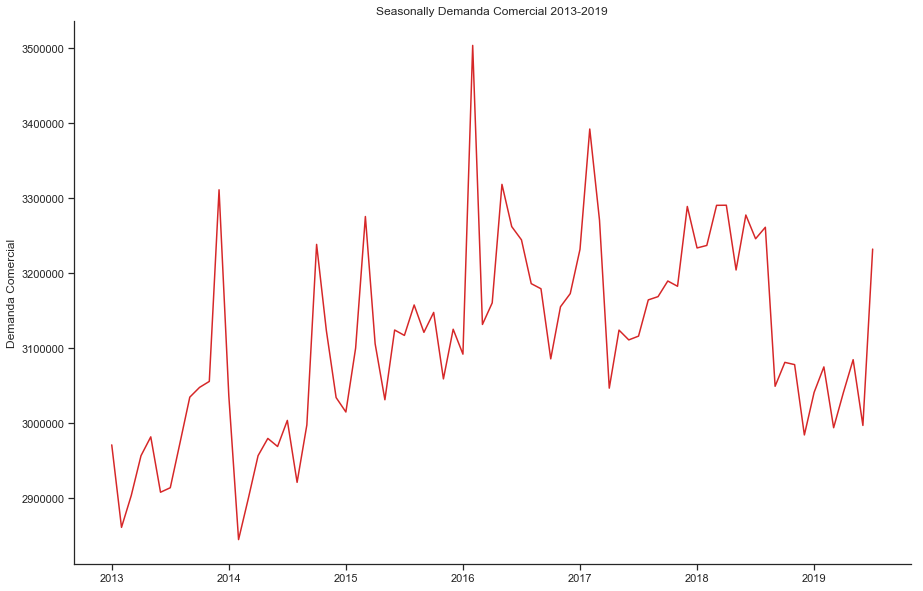

In [115]:
fig, ax= plt.subplots();#figsize=(9,6))
decomposition_com.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Demanda Comercial')
ax.set_title('Seasonally Demanda Comercial 2013-2019')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

Se usa el módulo <TT>plotting</TT> para graficar los componentes de la serie

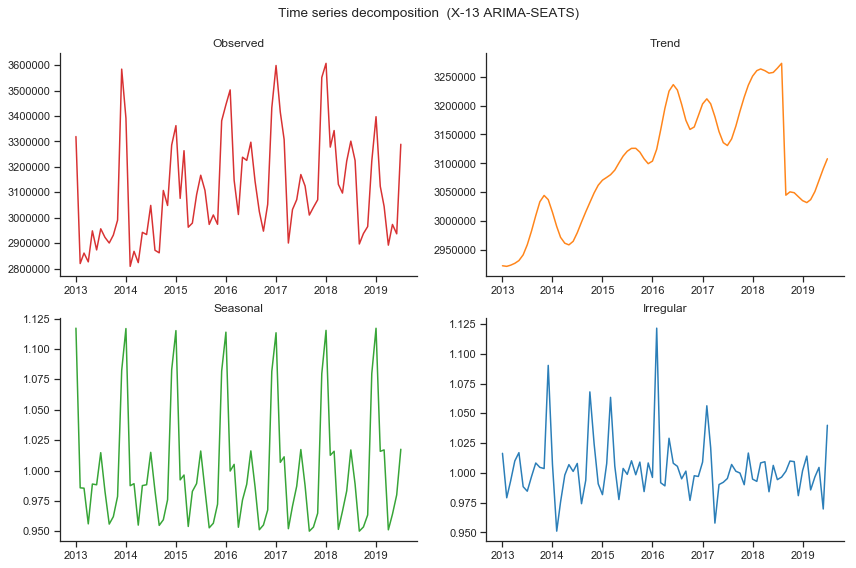

In [116]:
from plotting import plot_components_x13
plot_components_x13(decomposition_com)
plt.show()

El análisis de la serie descompuesta de Demanda Comercial es similar al de la demanda residencial ya que la tendencia y la estacionalidad se comportan de la misma forma.

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

##### Demanda Residencial

In [117]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [118]:
ahw_sm=sm.tsa.ExponentialSmoothing(y_res, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [119]:
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               325019.910


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,8345397406747.049
Optimized:,True,AIC,2037.279
Trend:,Additive,BIC,2075.191
Seasonal:,Additive,AICC,2048.679
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:21:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1013813,alpha,True
smoothing_slope,5.9572e-22,beta,True


In [120]:
mhw_sm=sm.tsa.ExponentialSmoothing(y_res, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               249758.947


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,4927982984521.504
Optimized:,True,AIC,1995.664
Trend:,Additive,BIC,2033.575
Seasonal:,Multiplicative,AICC,2007.064
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:21:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2749452,alpha,True
smoothing_slope,6.4215e-16,beta,True


In [121]:
mhw_damped=sm.tsa.ExponentialSmoothing(y_res, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               250884.819


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,4972512204439.331
Optimized:,True,AIC,1998.374
Trend:,Additive,BIC,2038.655
Seasonal:,Multiplicative,AICC,2011.256
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:21:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2915957,alpha,True
smoothing_slope,0.0526318,beta,True


The smoothed series based on the multiplicative method tracks the original series very closely.

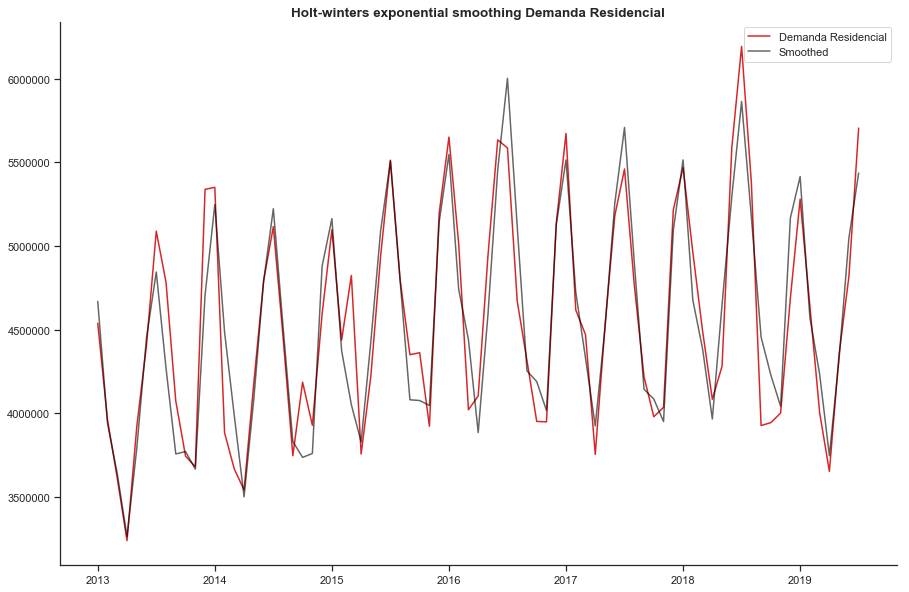

In [122]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y_res.index)

fig, ax= plt.subplots();

y_res['2013':].plot(color='#D62728', label='Demanda Residencial')
smoothed['2013':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title('Holt-winters exponential smoothing Demanda Residencial', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

#### Demanda Comercial

In [123]:
ahw_sm_com=sm.tsa.ExponentialSmoothing(y_com, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [124]:
hw_summary(ahw_sm_com)

 In-sample fit:
 RMSE               119419.112


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,1126613016892.270
Optimized:,True,AIC,1879.082
Trend:,Additive,BIC,1916.994
Seasonal:,Additive,AICC,1890.482
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:21:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2701004,alpha,True
smoothing_slope,3.3236e-12,beta,True


In [125]:
mhw_sm_com=sm.tsa.ExponentialSmoothing(y_com, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm_com)

 In-sample fit:
 RMSE               105239.899


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,874959467500.604
Optimized:,True,AIC,1859.112
Trend:,Additive,BIC,1897.023
Seasonal:,Multiplicative,AICC,1870.512
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:21:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3397293,alpha,True
smoothing_slope,5.8967e-14,beta,True


In [126]:
mhw_damped_com=sm.tsa.ExponentialSmoothing(y_com, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped_com)

 In-sample fit:
 RMSE               120298.567


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,1143267872518.632
Optimized:,True,AIC,1882.242
Trend:,Additive,BIC,1922.522
Seasonal:,Multiplicative,AICC,1895.123
Seasonal Periods:,12,Date:,"Mon, 30 Sep 2019"
Box-Cox:,False,Time:,20:21:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2105263,alpha,True
smoothing_slope,0.2105263,beta,True


The smoothed series based on the multiplicative method tracks the original series very closely.

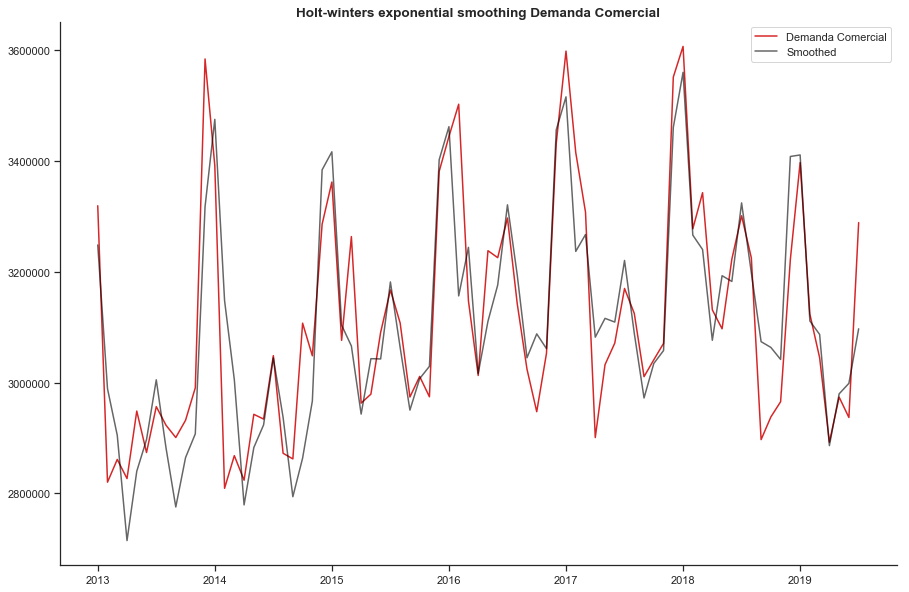

In [127]:
smoothed_com=pd.Series(mhw_sm_com.fittedvalues, index=y_com.index)

fig, ax= plt.subplots();

y_com['2013':].plot(color='#D62728', label='Demanda Comercial')
smoothed_com['2013':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title('Holt-winters exponential smoothing Demanda Comercial', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Diagnóstico del Modelo

Se realiza a continuación el análisis de los residuos del modelo.

#### Residuos Demanda Residencial

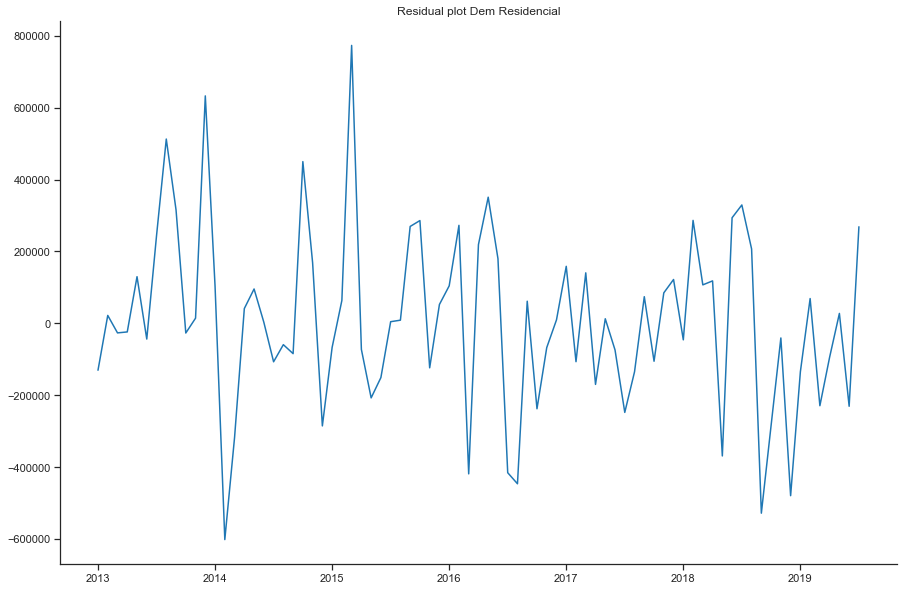

In [128]:
resid_res = (y_res-mhw_sm.fittedvalues)#[12:]

fig, ax= plt.subplots();
resid_res.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot Dem Residencial')
sns.despine()
plt.show()

Se observa un gráfico de los residuos de la demanda residencial con mucho ruido lo cual es bueno para nuestro modelo. A continuación, se gráfica la autocorrelación de los residuos.

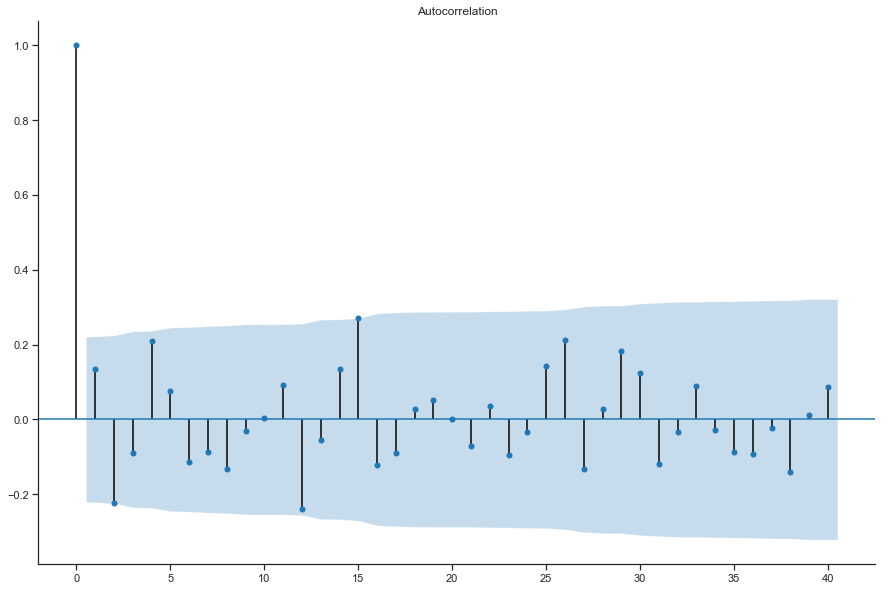

In [129]:
fig, ax = plt.subplots();
sm.graphics.tsa.plot_acf(resid_res, lags=40, ax=ax)
sns.despine()
plt.show()

C:\Users\Gabriel H\.conda\envs\diplodatos\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


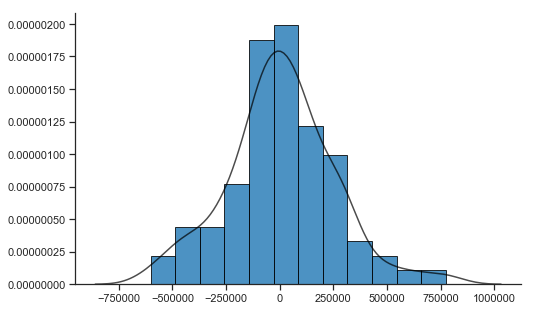

In [130]:
from plotting import histogram

histogram(resid_res)
plt.show()


Por último, al graficar la distribución de los residuos se observa una distribución normal.

#### Residuos Demanda Comercial

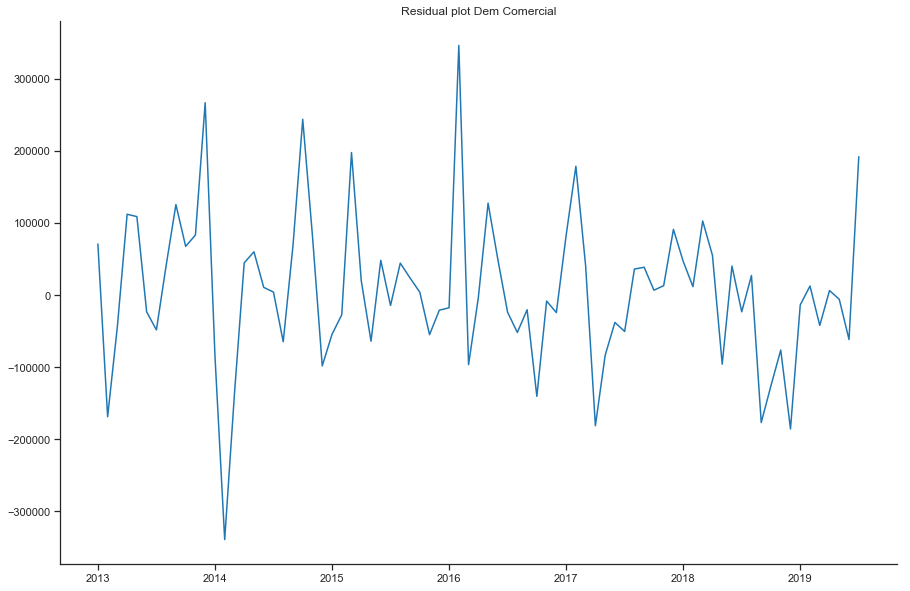

In [131]:
resid_com = (y_com-mhw_sm_com.fittedvalues)#[12:]

fig, ax= plt.subplots();
resid_com.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot Dem Comercial')
sns.despine()
plt.show()

Se observa un gráfico de los residuos de la demanda comercial con mucho ruido (mismo comportamiento de lo cual es bueno para nuestro modelo. A continuación, se gráfica la autocorrelación de los residuos.

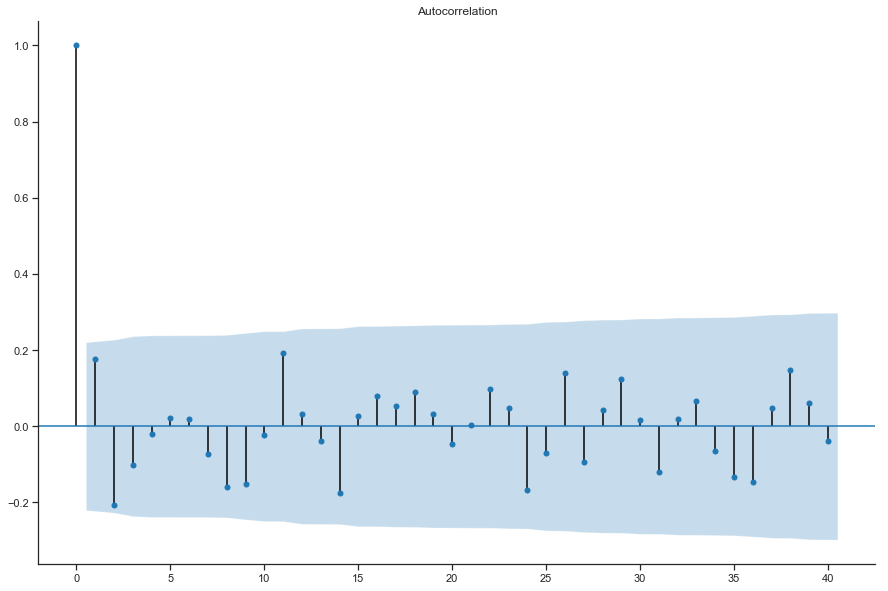

In [132]:
fig, ax = plt.subplots();
sm.graphics.tsa.plot_acf(resid_com, lags=40, ax=ax)
sns.despine()
plt.show()

C:\Users\Gabriel H\.conda\envs\diplodatos\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


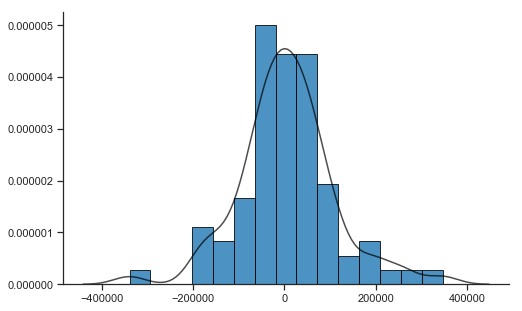

In [133]:
from plotting import histogram

histogram(resid_com)
plt.show()


Por último, al graficar la distribución de los residuos se observa una distribución normal

## Validación del Modelo


#### Demanda Residencial

In [134]:
start_val_res = y_res.index[-round(len(y_res)/12*.2)*12]
start_val_res

Period('2018-08', 'M')

In [135]:

validation=y_res[start_val_res:].index
start = y_res.index.get_loc(start_val_res) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y_res)):
    
    actual.append(y_res.iloc[i]) # actual value
    
    pred1.append(y_res.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y_res.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y_res.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

C:\Users\Gabriel H\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\Gabriel H\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\Gabriel H\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


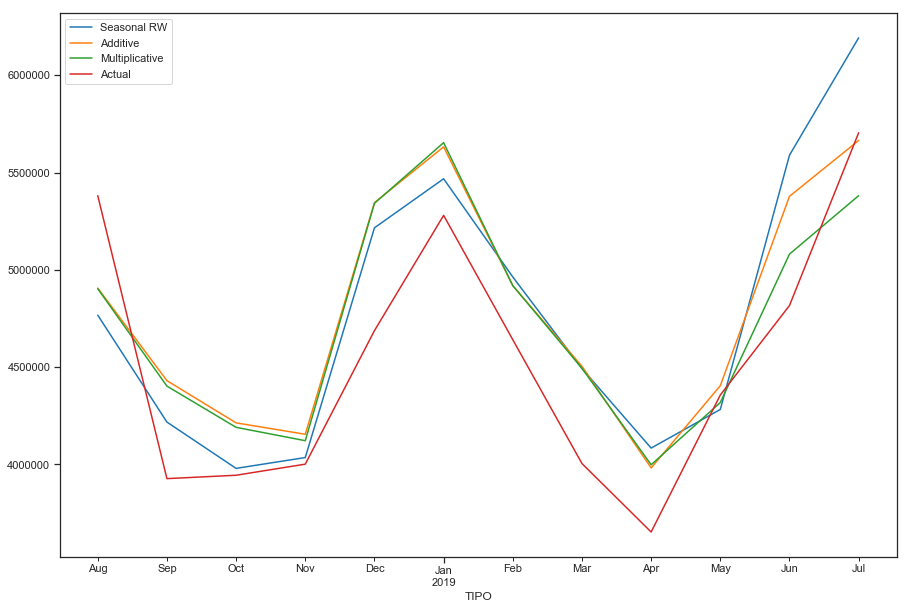

In [136]:
results.plot();

In [137]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,423173.552,104886.183
Additive,396541.964,89870.964
Multiplicative,377599.497,96442.172


#### Demanda Comercial

In [138]:
start_val_com = y_com.index[-round(len(y_com)/12*.2)*12]
start_val_com

Period('2018-08', 'M')

In [139]:

validation_com=y_com[start_val_com:].index
start_com = y_com.index.get_loc(start_val_com) 

pred1_com = [] # seasonal random walk
pred2_com = [] # additive holt winters
pred3_com = [] # multiplicative holt winters
actual_com= []

for i in range(start_com, len(y_com)):
    
    actual_com.append(y_com.iloc[i]) # actual value
    
    pred1_com.append(y_com.iloc[i-12]) # seasonal random walk forecast
    
    model_com = sm.tsa.ExponentialSmoothing(y_com.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2_com.append(model_com.forecast(1)[0]) # additive holt winters forecast
    
    model_com = sm.tsa.ExponentialSmoothing(y_com.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3_com.append(model_com.forecast(1)[0]) # multiplicate holt winters forecast
    

columns_com=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results_com = np.vstack([pred1_com,pred2_com,pred3_com,actual_com]).T
results_com = pd.DataFrame(results_com, columns=columns_com, index=validation_com)

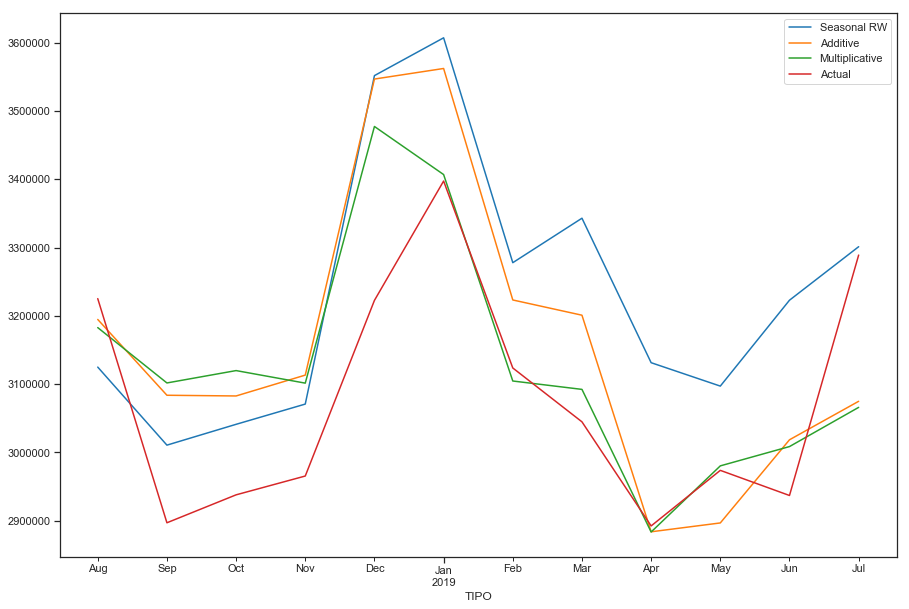

In [140]:
results_com.plot();

In [141]:
from scipy import stats

table_com = pd.DataFrame(0.0, index=results_com.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results_com.columns)-1):
    table_com.iloc[i,0] = sm.tools.eval_measures.rmse(results_com.iloc[:,i], results_com.iloc[:,-1])
    table_com.iloc[i,1] = (results_com.iloc[:,i] - results_com.iloc[:,-1]).sem()
table_com.round(3)

,RMSE,SE
Seasonal RW,196566.642,36019.872
Additive,158999.424,41208.621
Multiplicative,134691.837,37515.382


Resumen de tablas Residencial y Comercial

In [142]:
#Ajuste DF Tabla Residencial
table_res_com = table.reset_index()
table_res_com = table_res_com.rename(columns={"index": 'Model'})
table_res_com['Demanda'] = 'Residencial'

#Ajuste DF Tabla Comercial
table_com_plana = table_com.reset_index()
table_com_plana = table_com_plana.rename(columns={"index": 'Model'})
table_com_plana['Demanda'] = 'Comercial'

table_res_com = table_res_com.append(table_com_plana)
table_res_com.set_index(['Demanda'])


,Model,RMSE,SE
Demanda,,,
Residencial,Seasonal RW,423173.552489,104886.182651
Residencial,Additive,396541.963797,89870.964150
Residencial,Multiplicative,377599.496517,96442.172001
Comercial,Seasonal RW,196566.641834,36019.872294
Comercial,Additive,158999.423631,41208.620887
Comercial,Multiplicative,134691.836544,37515.381923


## Forecast


#### Demanda Residencial

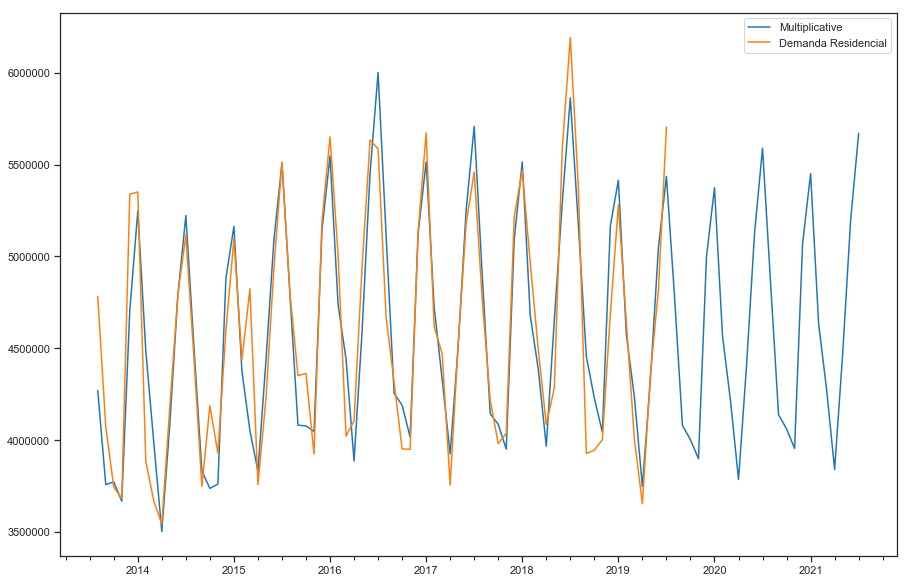

In [143]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y_res, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['Demanda Residencial'] = y_res

plot[-(w+h):].plot();#figsize=(9,6))

#### Demanda Residencial

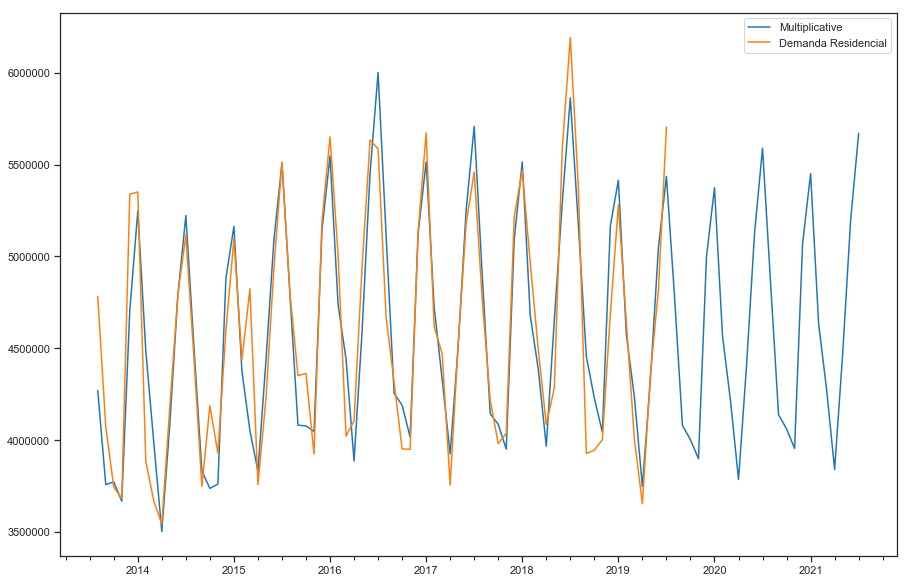

In [144]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y_res, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['Demanda Residencial'] = y_res

plot[-(w+h):].plot();#figsize=(9,6))

#### Demanda Comercial

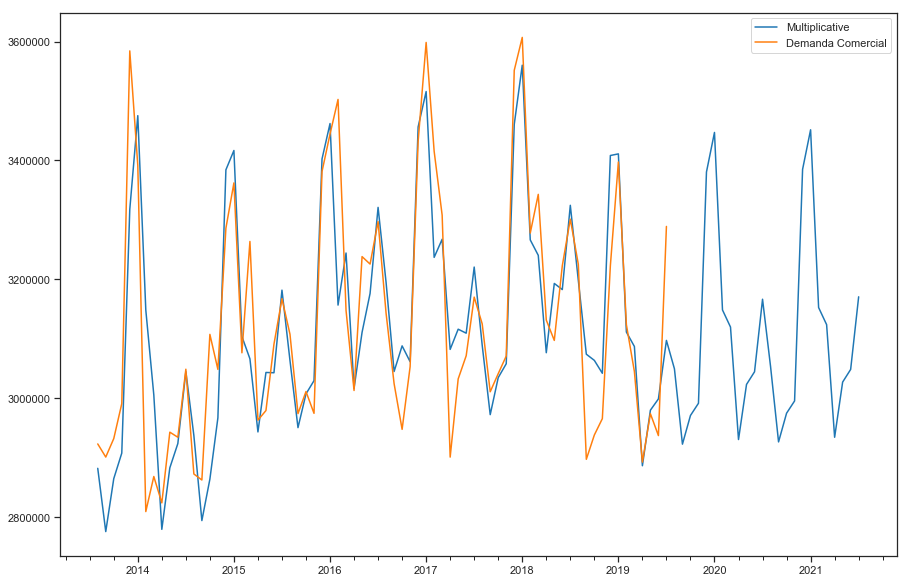

In [145]:
h_com=2*12 #M
w_com=h_com*3

model_com = sm.tsa.ExponentialSmoothing(y_com, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

plot_com = pd.DataFrame()
plot_com['Multiplicative'] = pd.concat([model_com.fittedvalues, model_com.forecast(h_com)])
plot_com['Demanda Comercial'] = y_com

plot_com[-(w_com+h_com):].plot();